# Text Graph: Graph Representation of Tokens and Documents

In [ ]:
import pandas as pd
df = pd.read_csv(r"C:\Users\user\Documents\RenewableEnergy_patents_2023_abstract_cpc.csv", index_col = 0)

## Customized Tokenizer

In [7]:
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
from spacy.language import Language
from spacy.util import filter_spans

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Define rule-based matcher
matcher = Matcher(nlp.vocab)
patterns = [
    [{'POS': 'NOUN'}, {'POS': 'NOUN'}, {'POS': 'NOUN'}],
    [{'POS': 'NOUN'}, {'POS': 'NOUN'}],
    [{'POS': 'ADJ'}, {'POS': 'NOUN'}]
]
matcher.add("Patterns", patterns)

# Custom pipeline component for rule-based matching
@Language.component('merge_rule_based_matches')
def merge_rule_based_matches(doc):
    matches = matcher(doc)
    spans = [Span(doc, start, end, label=match_id) for match_id, start, end in matches]
    # Filter spans to remove overlaps
    filtered_spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        for span in filtered_spans:
            retokenizer.merge(span)
    return doc

# Add the custom component to the pipeline before the 'ner' component
nlp.add_pipe('merge_rule_based_matches', before="ner")

# Custom tokenizer to handle hyphenated words and integrated with rule-based matching
def custom_tokenizer(nlp):
    prefix_re = spacy.util.compile_prefix_regex(nlp.Defaults.prefixes) # use default
    suffix_re = spacy.util.compile_suffix_regex(nlp.Defaults.suffixes) # use default
    infix_re = spacy.util.compile_infix_regex(nlp.Defaults.infixes + [r'\w+-\w+'])
    return spacy.tokenizer.Tokenizer(nlp.vocab, 
                                     prefix_search = prefix_re.search,
                                     suffix_search = suffix_re.search,
                                     infix_finditer=infix_re.finditer, 
                                     token_match=None)

nlp.tokenizer = custom_tokenizer(nlp)

In [8]:
# Preprocessing

# Words to exclude
exclude_words = {"include", "have", "provide", "receive", "method", "comprise", "configure", 
                 "define", "disclose", "determine", "identify", "second", "relate", "enable", 
                 "present", "plurality", "e.g", "thereof", "involve", "describe", "substantially",
                 "particularly", "1", "2", "relative", "particular", "aspect", "correspond"}

def custom_tokenizer_preprocessed(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower().strip()
        for token in doc
        if token.lemma_.lower().strip() not in exclude_words
        and not token.is_stop
        and not token.is_punct
        and not token.is_space
    ]
    return tokens

## Bag of Words & Tf-Idf

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Use CountVectorizer with the custom spaCy tokenizer
vectorizer = CountVectorizer(tokenizer=custom_tokenizer_preprocessed, min_df=5, max_df=100, ngram_range=(1,1))
bof = vectorizer.fit_transform(df['abstract'])

# Use TfidfTransformer to transform bag of words
tfidf = TfidfTransformer()
tfidf_bof = tfidf.fit_transform(bof)

C:\Users\user\miniconda3\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Token-Token Graph: BoW

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# sparse matrix -> dense matrix
dense_matrix = bof.toarray()

# token co-occurence matrix, token*token square matrix
token_matrix = np.dot(dense_matrix.T, dense_matrix)
np.fill_diagonal(token_matrix, 0)

token_matrix.shape

(299, 299)

In [11]:
# create graph
G = nx.Graph()

# token list
tokens = list(vectorizer.vocabulary_.keys())

# token as nodes
for token in tokens:
    G.add_node(token)

# add edges
for i in range(len(tokens)):
    for j in range(i + 1, len(tokens)):
        weight = token_matrix[i, j]
        if weight >= 10: ## filter out edges with weight lower than 10
            G.add_edge(tokens[i], tokens[j], weight=weight)


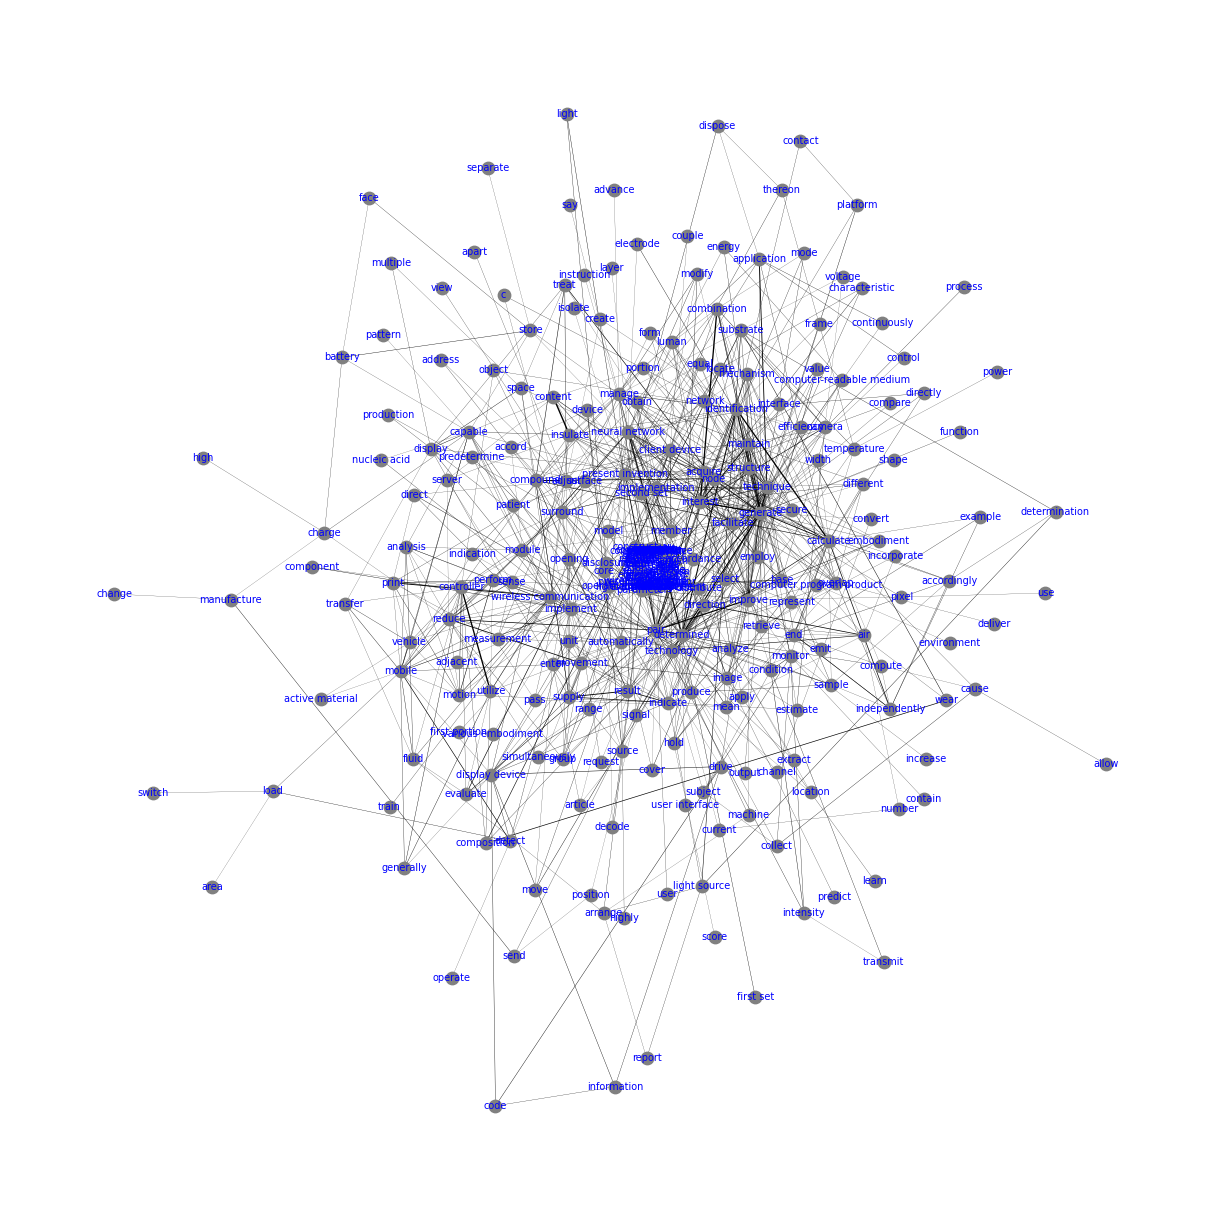

In [12]:
# visualize token graph

# Define edge widths based on weights
edges = G.edges(data=True)
edge_widths = [data['weight'] for _, _, data in edges]

plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_size=80, node_color="gray", font_size=7, font_color = "blue", 
        width = edge_widths/max(edge_widths))
plt.show()

## Token-Token Graph: Tf-Idf

In [22]:
# sparse matrix -> dense matrix
dense_matrix = tfidf_bof.toarray()

# token co-occurence matrix, token*token square matrix
token_matrix = np.dot(dense_matrix.T, dense_matrix)
np.fill_diagonal(token_matrix, 0)

token_matrix.shape

(299, 299)

In [40]:
# create graph
G = nx.Graph()

# token list
tokens = list(vectorizer.vocabulary_.keys())

# token as nodes
for token in tokens:
    G.add_node(token)

# add edges
for i in range(len(tokens)):
    for j in range(i + 1, len(tokens)):
        weight = token_matrix[i, j]
        if weight > 0.12:
            G.add_edge(tokens[i], tokens[j], weight=weight)

In [27]:
pd.Series(edge_widths).describe()

count    11437.000000
mean         0.096396
std          0.091561
min          0.003876
25%          0.037210
50%          0.068712
75%          0.124255
max          1.121245
dtype: float64

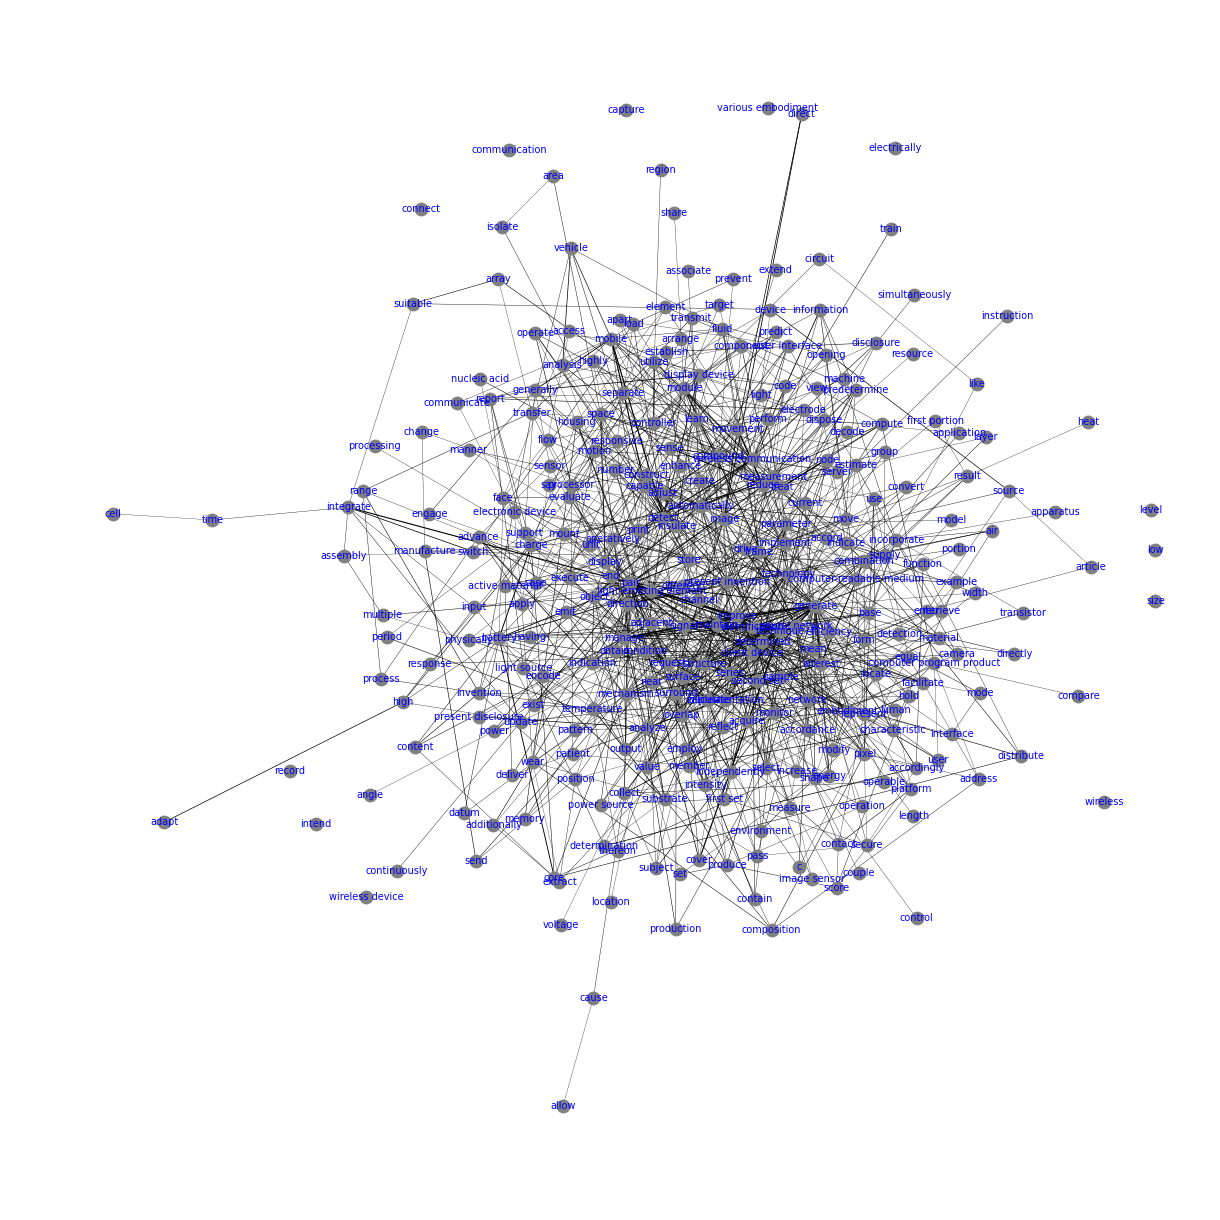

In [41]:
# visualize token graph

# Define edge widths based on weights
edges = G.edges(data=True)
edge_widths = [data['weight'] for _, _, data in edges]

plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_size=80, node_color="gray", font_size=7, font_color = "blue", 
        width = edge_widths)
plt.show()

## Document-Document Graph: BoW

In [81]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [42]:
dense_matrix = bof.toarray()

# patent concept overlapping matrix, patent*patent square matrix
patent_matrix = np.dot(dense_matrix, dense_matrix.T)
np.fill_diagonal(patent_matrix, 0)

patent_matrix.shape

(360, 360)

In [43]:
# create graph
G = nx.Graph()

# patent list
patents = list(df['id'])

# patent as nodes
for patent in patents:
    G.add_node(patent)

# add edges
for i in range(len(patents)):
    for j in range(i + 1, len(patents)):
        weight = patent_matrix[i, j]
        if weight >= 7: ## filter out edges with weight lower than 7
            G.add_edge(patents[i], patents[j], weight=weight)


# Define edge widths based on weights
edges = G.edges(data=True)
edge_widths = [data['weight'] for _, _, data in edges]

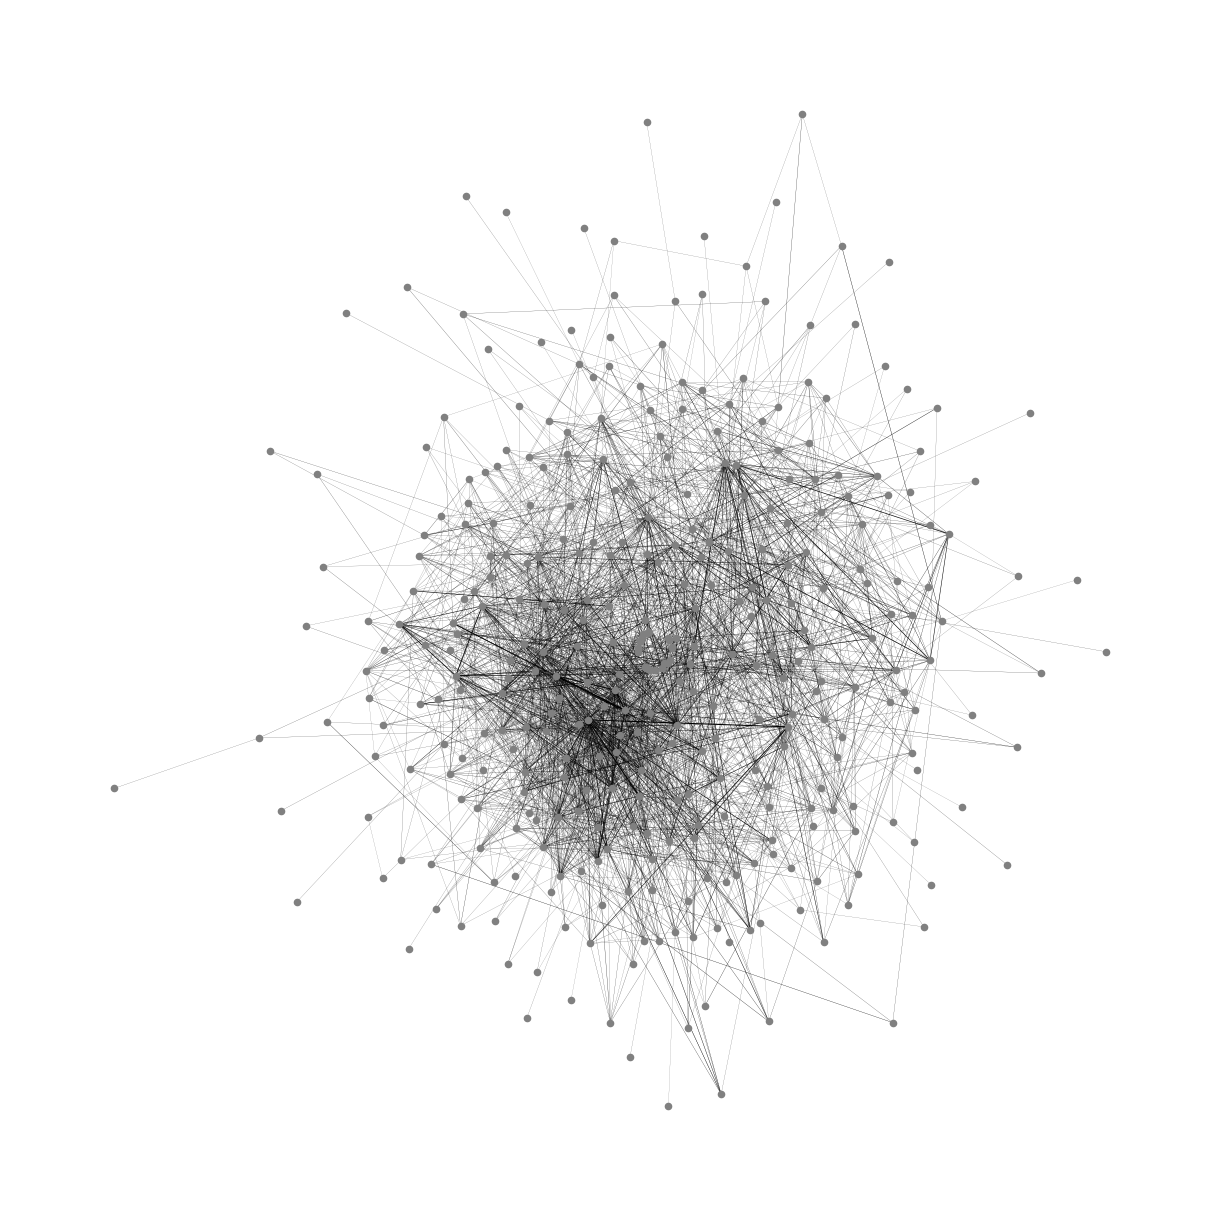

In [44]:
# visualize token graph
plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=False, node_size=20, node_color="grey", width = edge_widths/max(edge_widths))
plt.show()

## Document-Document Graph: Tf-Idf

In [45]:
dense_matrix = tfidf_bof.toarray()

# patent concept overlapping matrix, patent*patent square matrix
patent_matrix = np.dot(dense_matrix, dense_matrix.T)
np.fill_diagonal(patent_matrix, 0)

patent_matrix.shape

(360, 360)

In [61]:
# create graph
G = nx.Graph()

# patent list
patents = list(df['id'])

# patent as nodes
for patent in patents:
    G.add_node(patent)

# add edges
for i in range(len(patents)):
    for j in range(i + 1, len(patents)):
        weight = patent_matrix[i, j]
        if weight >= 0.2: 
            G.add_edge(patents[i], patents[j], weight=weight)


# Define edge widths based on weights
edges = G.edges(data=True)
edge_widths = [data['weight'] for _, _, data in edges]

In [48]:
pd.Series(edge_widths).describe()

count    21452.000000
mean         0.091566
std          0.090022
min          0.002679
25%          0.032463
50%          0.061512
75%          0.116950
max          0.777223
dtype: float64

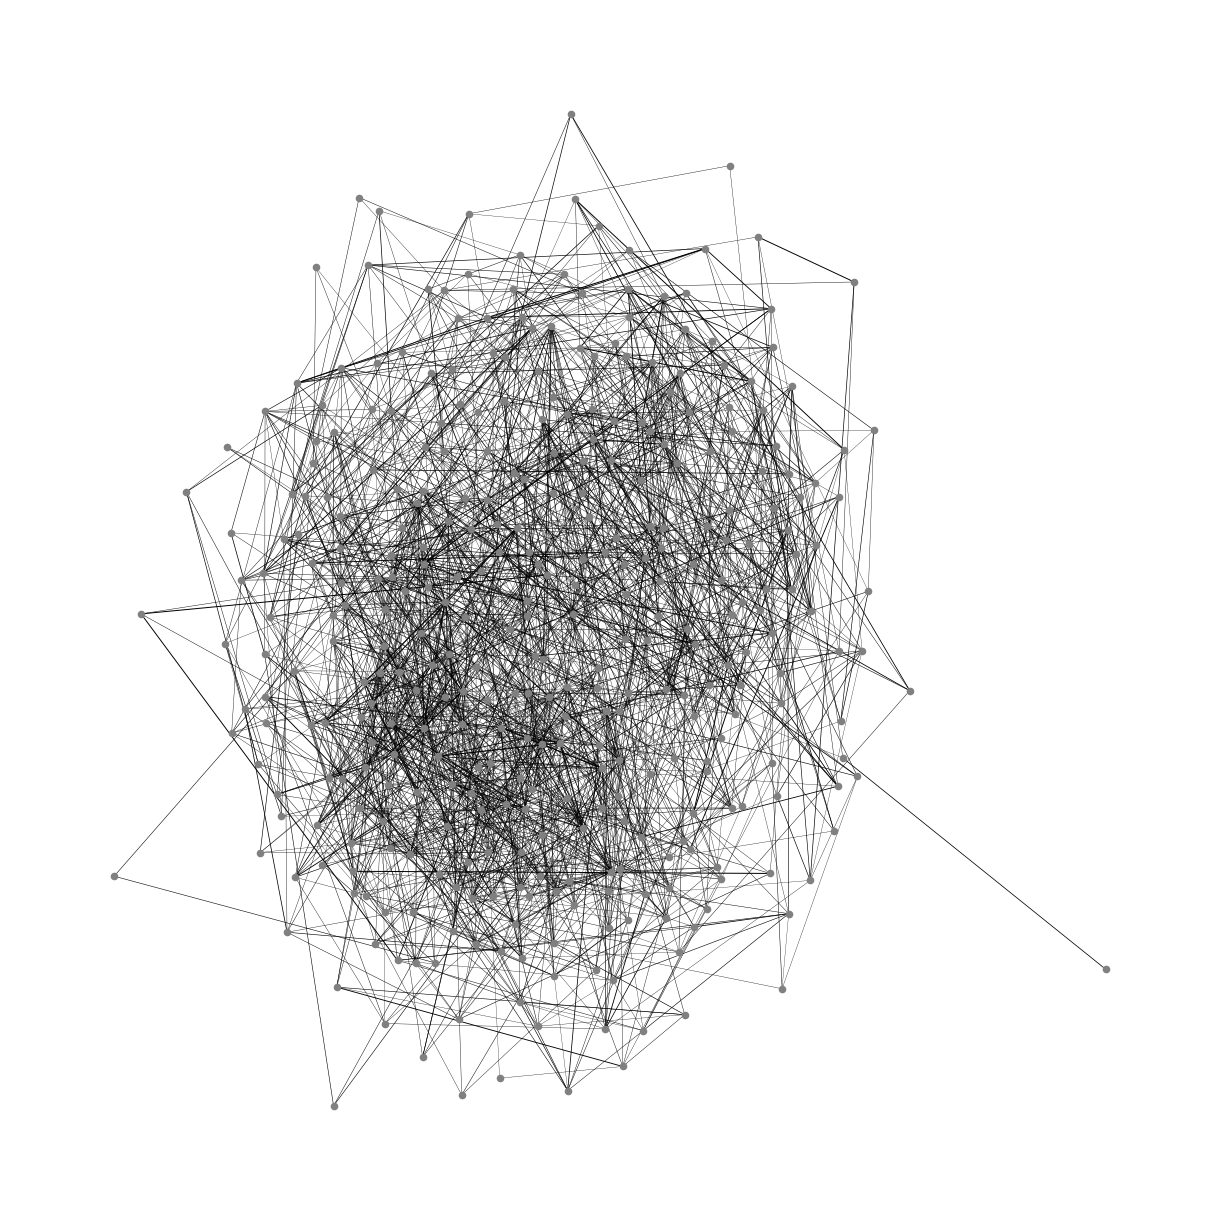

In [62]:
# visualize token graph
plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=False, node_size=20, node_color="grey", width = edge_widths)
plt.show()